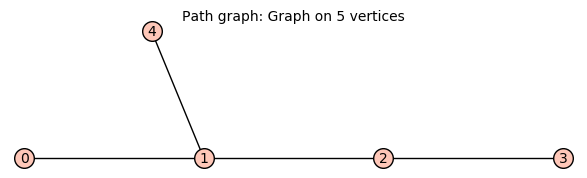

In [3]:
import random

def nakljucni_graf(st_vozlisc, premer):
    pot = graphs.PathGraph(premer + 1)
    i = premer + 1
    while i < st_vozlisc:
        pot1 = Graph(pot)
        pot1.add_edge(random.randint(1, i - 1), i)
        if pot1.diameter() <= premer:
            pot = Graph(pot1)
            i = i + 1
    #print(pot.degree())
    #print(pot.to_dictionary())#vrne slovar tock in njenih povezav (naredi isto kot nasa funkcija seznam_slovarjev_dreves)
    #pot.show()
    return pot

def zacetna_populacija(st_vozlisc, premer, stevilo_osebkov=10): #ustvari zacetno populacijo, ki jo bomo potem razvijali (recimo, da je maksimalno 20 osebkov)
    zacetna_populacija = []
    i = 0
    while i < stevilo_osebkov:
        osebek = nakljucni_graf(st_vozlisc, premer)
        zacetna_populacija.append(osebek.to_dictionary())
        i = i + 1
    return zacetna_populacija

def fitness(seznam_dreves): #iscemo iskano optimalno lastnost, se pravi Wienerjev indeks
    index = 0 #neko majhno število, da bojo naslednji indeksi gotovo večji
    for drevo in seznam_dreves:
        graf_drevesa = Graph(drevo)
        if graf_drevesa.wiener_index() > index:
            index = graf_drevesa.wiener_index()
            drevo_max_index = drevo
    #Graph(drevo_max_index).show()
    return drevo_max_index

def mutate(drevo, verjetnost = 0.02):
    kopija_drevo = Graph(drevo)
    listki = []
    if random.random() <= verjetnost:
        for i in range(0, len(kopija_drevo.degree())):
            if kopija_drevo.degree()[i] == 1:
                listki.append(i)
        izbrano_vozlisce_listka = random.choice(listki)
        kopija_drevo.delete_edge(izbrano_vozlisce_listka, kopija_drevo.neighbors(izbrano_vozlisce_listka)[0])
        vozlisca_drevo = kopija_drevo.vertices()
        del vozlisca_drevo[izbrano_vozlisce_listka]
        kopija_drevo.add_edge(izbrano_vozlisce_listka, random.choice(vozlisca_drevo)) #nekako je treba se izločit vozlišče, ki ga pripenjaš
        if kopija_drevo.diameter() == Graph(drevo).diameter():
            #kopija_drevo.show()
            #print(kopija_drevo.to_dictionary())
            return Graph(kopija_drevo).to_dictionary()          
        else:
            return mutate(drevo)
    else:
        #kopija_drevo.show()
        return Graph(drevo).to_dictionary()
#Nisem prepričan, da je funkcija uredu, kaj če hočmo mutirat graf poti, kjer pot razpdae na dva dela...
        

def mutacije(drevo, verjetnost): # nepotrebna funkcija, uporabil sem jo le pri preverjanju, če naredim več mutacij, da res vedno pride različno (naključno)
    vse_mutacije = []
    for i in range(0, 100):
        vse_mutacije.append(mutate(drevo, verjetnost))
    return vse_mutacije

def crossover(drevo1, drevo2):
    
    kopija_drevo1 = Graph(drevo1)
    kopija_drevo2 = Graph(drevo2)

    izbrano_vozlisce1 = random.randint(0, kopija_drevo1.order() - 1) #izberemo vozlišče kjer bomo razpolovili graf
    izbrano_vozlisce2 = random.randint(0, kopija_drevo2.order() - 1)
    sosed_vozlisca1 = random.choice(kopija_drevo1.neighbors(izbrano_vozlisce1)) #izberemo soseda vozlisca, kjer bomo razpolovili graf
    sosed_vozlisca2 = random.choice(kopija_drevo2.neighbors(izbrano_vozlisce2))

    kopija_drevo1.delete_edge(izbrano_vozlisce1, sosed_vozlisca1) #naključno odstranimo povezavo
    kopija_drevo2.delete_edge(izbrano_vozlisce2, sosed_vozlisca2)

    kopija_drevo1_a = kopija_drevo1.subgraph(kopija_drevo1.connected_component_containing_vertex(izbrano_vozlisce1)) #naredimo podgrafe
    kopija_drevo1_b = kopija_drevo1.subgraph(kopija_drevo1.connected_component_containing_vertex(sosed_vozlisca1))
    kopija_drevo2_a = kopija_drevo2.subgraph(kopija_drevo2.connected_component_containing_vertex(izbrano_vozlisce2))
    kopija_drevo2_b = kopija_drevo2.subgraph(kopija_drevo2.connected_component_containing_vertex(sosed_vozlisca2))

    novo_drevo1 = kopija_drevo1_a.disjoint_union(kopija_drevo2_b) #povezemo dva podgrafa v nov graf
    novo_drevo1.add_edge((0, izbrano_vozlisce1), (1, sosed_vozlisca2))
    novo_drevo1.relabel()

    novo_drevo2 = kopija_drevo2_a.disjoint_union(kopija_drevo1_b) #povezemo dva podgrafa v nov graf
    novo_drevo2.add_edge((0, izbrano_vozlisce2), (1, sosed_vozlisca1))
    novo_drevo2.relabel()

    
    if novo_drevo1.diameter() <= Graph(drevo1).diameter() and novo_drevo2.diameter() <= Graph(drevo1).diameter() and novo_drevo1.order() == novo_drevo2.order() and novo_drevo1.order() == Graph(drevo1).order():
        #preverimo, če se premer in število vozlišč ohrani
        #novo_drevo1.show()
        #novo_drevo2.show()
        return [novo_drevo1.to_dictionary(), novo_drevo2.to_dictionary()]

    else:
        return [drevo1, drevo2]

def nova_generacija(zacetna_generacija, verjetnost): #definira novo generacijo osebkov
    nova_generacija = []
    a = 0
    i = len(zacetna_generacija)//10 + 1
    while a < i:
        nova_generacija.append(fitness(zacetna_generacija))
        a += 1
    while i < len(zacetna_generacija):

        drevo1 = random.choice(zacetna_generacija)
        drevo2 = random.choice(zacetna_generacija)
        mutirano_drevo1 = mutate(drevo1, verjetnost)
        mutirano_drevo2 = mutate(drevo2, verjetnost)
        novi_drevesi = crossover(mutirano_drevo1, mutirano_drevo2)
        novo_drevo1 = novi_drevesi[0]
        novo_drevo2 = novi_drevesi[1]
        optimalno_drevo = fitness([novo_drevo1, novo_drevo2, mutirano_drevo1, mutirano_drevo2, drevo1, drevo2])
        
        nova_generacija.append(optimalno_drevo)

        i = i + 1

    return  nova_generacija


def simulacija(st_vozlisc, premer, stevilo_osebkov, stevilo_generacij, verjetnost): #požene program in išče graf z max wiener indeksom
    populacija = zacetna_populacija(st_vozlisc, premer, stevilo_osebkov)
    i = 0
    while i < stevilo_generacij:
        populacija = nova_generacija(populacija, verjetnost)
        i = i + 1
    return fitness(populacija), Graph(fitness(populacija)).wiener_index(), Graph(fitness(populacija)).show()

In [0]:
simulacija(17, 3, 10, 50, 0.02)